In [8]:
using DrWatson
@quickactivate :NARMAXExperiments

In [13]:
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using ForneyLab
using NARMAX
import ProgressMeter
using CSV
using DataFrames
using Statistics
using MAT


In [14]:
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, Gamma

In [15]:
include("../src/polynomial.jl")
include("../src/data.jl");

## Load generated signal

In [30]:
# Load from .mat file
mat_data = matread("../datasets/verification/realizations/NARMAXsignal_stde0.05_degree3_delays4_D22_r9.mat")

train_size = 200
test_size = 1000

# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:train_size) .+ transient

# Length of testing signal
ix_tst = collect(1:test_size) .+ transient;

# Extract data sets
input_trn = mat_data["uTrain"][ix_trn]
noise_trn = mat_data["eTrain"][ix_trn]
output_trn = mat_data["yTrain"][ix_trn]
T_trn = length(input_trn)

input_tst = mat_data["uTest"][ix_tst]
noise_tst = mat_data["eTest"][ix_tst]
output_tst = mat_data["yTest"][ix_tst]
T_tst = length(input_tst)

# System parameters
η_true = mat_data["system"]["theta"][:]
τ_true = inv(mat_data["options"]["stde"]^2);

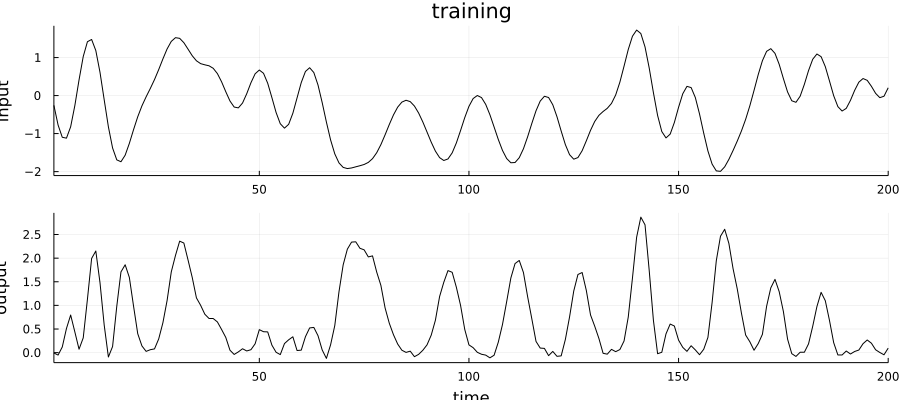

In [31]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1), xlims=(1, train_size))

In [32]:
function model_specification(ϕ; M1=M1, M2=M2, M3=M3, N=N)

    graph = FactorGraph()

    # Observed variables
    @RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
    @RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
    @RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
    @RV u_k; placeholder(u_k, :u_k)

    # Time-invariant parameters
    @RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
    @RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N,N)))

    # Likelihood
    @RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
    placeholder(y_k, :y_k)

    q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
    algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
    return algorithmSourceCode(algorithm, free_energy=true)
    
end

model_specification (generic function with 1 method)

In [33]:
function experiment_FEM(input_trn, output_trn, input_tst, output_tst, ϕ, priors; M1=1, M2=1, M3=1, N=3, num_iters=5, computeFE=false)

    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    "Inference execution"

    # Extract prior parameters
    θ_k = priors["θ"]
    τ_k = priors["τ"]

    # Initialize marginals
    marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_k[1], w=θ_k[2]),
                     :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

    # Preallocate free energy array
    Fq = zeros(T_trn-maxM, num_iters)

    # Preallocate parameter arrays
    params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
    params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

    # Preallocate prediction arrays
    predictions = (zeros(T_trn,), zeros(T_trn,))
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)
        
        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

        # Compute prediction error
        errors[k] = output_trn[k] - predictions[1][k]
        
        # Set data 
        data = Dict(:y_k => output_trn[k],
                    :u_k => input_trn[k],
                    :u_kmin1 => u_kmin1,
                    :y_kmin1 => y_kmin1,
                    :e_kmin1 => e_kmin1,
                    :m_θ => θ_k[1],
                    :w_θ => θ_k[2],
                    :a_τ => τ_k[1],
                    :b_τ => τ_k[2])
        
        # Iterate updates
        for n = 1:num_iters
            
            # Compute free energy
            if computeFE
                Fq[ii,n] = freeEnergy(data,marginals)
            end
            
            # Update parameters
            stepθ!(data, marginals)
            stepτ!(data, marginals)
            
        end 
        
        # Update params
        θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
        τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
        
        # Store params
        params_θ[1][ii,:] = θ_k[1]
        params_θ[2][ii,:,:] = θ_k[2]
        params_τ[1][ii] = τ_k[1]
        params_τ[2][ii] = τ_k[2]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = (zeros(T_tst,), zeros(T_tst,))
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

        # Update error
        errors[k] = output_tst[k] - predictions[1][k]
        
    end

    "Simulation"

    # Prepare array
    simulations = (zeros(T_tst,), zeros(T_tst,))

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[1][k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[1][k] = θ_k[1]'*ϕx
        
        simulations[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[1][maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

    if computeFE
        return RMS_sim, RMS_prd, Fq
    else
        return RMS_sim, RMS_prd, simulations, predictions, θ_k
    end
end

experiment_FEM (generic function with 1 method)

In [34]:
function experiment_RLS(input_trn, output_trn, input_tst, output_tst, ϕ; M1=1, M2=1, M3=1, N=1, λ=1.00)
    
    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    # Parameters
    P = λ.*Matrix{Float64}(I,N,N)
    w_k = zeros(N,)

    # Preallocate prediction array
    predictions = zeros(T_trn,)
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)

        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        # Update data vector
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        
        # Update weights
        α = output_trn[k] - w_k'*ϕx 
        g = P*ϕx*inv(λ + ϕx'*P*ϕx)
        P = inv(λ)*P - g*ϕx'*inv(λ)*P
        w_k = w_k + α*g
        
        # Prediction
        predictions[k] = w_k'*ϕx
        errors[k] = output_trn[k] - predictions[k]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = zeros(T_tst,)
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[k] = w_k'*ϕx

        # Update error
        errors[k] = output_tst[k] - predictions[k]
        
    end

    "Simulation"

    # Prepare array
    simulations = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[k] = w_k'*ϕx
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[maxM+1:end] - output_tst[maxM+1:end]).^2))

    return RMS_sim, RMS_prd, simulations, predictions, w_k
end

experiment_RLS (generic function with 1 method)

In [35]:
# find order
M1, M2, M3 = 1, 1, 1
poly_order = 3
options = Dict("na"=>M1, "nb"=>M2, "ne"=>M3, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)

PΦ = gen_combs(options)
ϕ_fl(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)]
N = size(PΦ,2)

22

In [36]:
# Specify model and compile update functions
source_code = model_specification(ϕ_fl, M1=M1, M2=M2, M3=M3, N=N)
eval(Meta.parse(source_code))

freeEnergy (generic function with 1 method)

In [37]:
println(source_code)

begin

function stepτ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_τ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_τ]))
messages[2] = ruleVariationalNARMAXIn6PPPPPPN(ϕ_fl, ProbabilityDistribution(Univariate, PointMass, m=data[:y_k]), marginals[:θ], ProbabilityDistribution(Univariate, PointMass, m=data[:u_k]), ProbabilityDistribution(Multivariate, PointMass, m=data[:u_kmin1]), ProbabilityDistribution(Multivariate, PointMass, m=data[:y_kmin1]), ProbabilityDistribution(Multivariate, PointMass, m=data[:e_kmin1]), nothing)

marginals[:τ] = messages[1].dist * messages[2].dist

return marginals

end

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistributio

In [38]:
# Initialize priors
priors = Dict("θ" => (zeros(N,), Matrix{Float64}(I,N,N)), 
              "τ" => (1.0, 1.0))
prior_mτ = priors["τ"][1] ./ priors["τ"][2]  

1.0

In [39]:
rms_sim, rms_pred, sim, pred, coefs = experiment_FEM(input_trn, output_trn, input_tst, output_tst, ϕ_fl, priors, M1=M1, M2=M2, M3=M3, N=N, num_iters=20, computeFE=false)

(0.07517150104306476, 0.09022556596401596, ([0.0, -0.21527733501208454, 0.6906820930329833, 0.5831176881900241, 0.25506703921477564, 0.07989171394900875, 0.2441621967575573, 0.714507869474522, 1.2573755538774283, 1.5527571886597487  …  0.038070288872427346, 0.059782042971416975, 0.1665688991107052, 0.31125130037913795, 0.4618818557286793, 0.6051274150982483, 0.7384385103407385, 0.857171481630802, 0.9431275034734875, 0.9611404579302993], [0.0, 0.5554012861884259, 0.2334331297111467, 0.0929554459420931, 0.09202458145918678, 0.0921998095418924, 0.09156804084972436, 0.08960130300220194, 0.0920021112799597, 0.09442675404937781  …  0.08240625803856028, 0.08111927103204691, 0.08130675925938013, 0.08244622866068568, 0.08381772192647227, 0.0849969365601647, 0.08599422130708503, 0.08677639381200421, 0.08715491313226535, 0.08706212529351894]), ([0.0, -0.21527733501208454, 0.6931607708460465, 0.5805165302185016, 0.25899756390436585, 0.07387565789998633, 0.2320097976861747, 0.719987382877325, 1.267

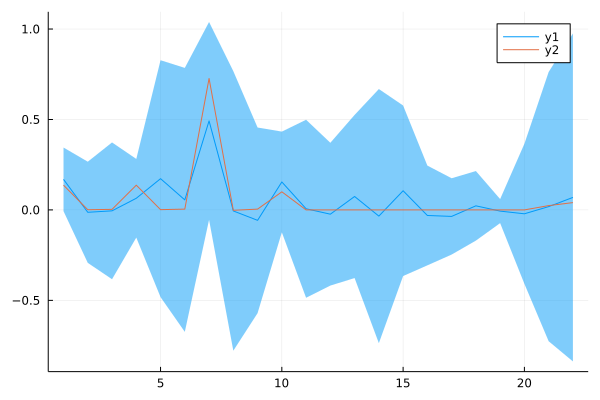

In [40]:
plot(coefs[1], ribbon=sqrt.(diag(inv(coefs[2]))))
plot!(η_true)


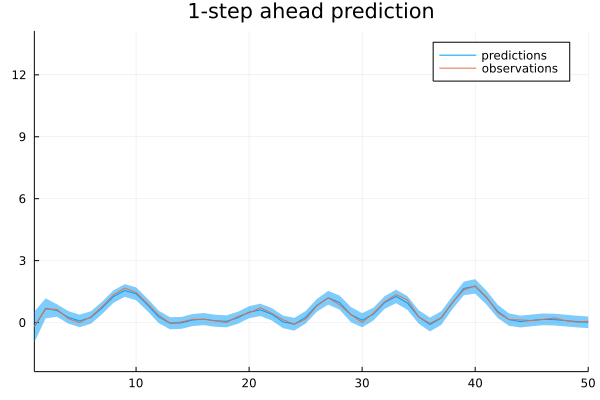

In [41]:
plot(sim[1][2:end], ribbon=sqrt.(sim[2][2:end]), label="predictions")
plot!(output_tst[1:end], xlims=(1, 50), title="1-step ahead prediction", label="observations")

In [42]:
rms_sim, rms_pred, sim, pred, coefs = experiment_RLS(input_trn, output_trn, input_tst, output_tst, ϕ_fl, M1=M1, M2=M2, M3=M3, N=N, λ=1.0)

(0.0942994899753636, 0.13584970175652575, [0.0, -0.2322630525154118, 0.6446291726555923, 0.5591918648273392, 0.24057149143924272, 0.07798615038690873, 0.25439749478326246, 0.7189724046685807, 1.243191503113181, 1.5290624072362413  …  0.03548821441332733, 0.05784609234507294, 0.16241399323357428, 0.3036691593713782, 0.4519638515593625, 0.5948129383363159, 0.7290537718812562, 0.8488446894712857, 0.9349384498386129, 0.9518786648675321], [0.0, -0.2322630525154118, 0.6513249346948857, 0.5611197366629177, 0.25200548586741217, 0.07008015416869492, 0.23726389502591608, 0.7248597845510357, 1.2571427854763308, 1.5533745589312016  …  0.03393226201768535, 0.04020411218066881, 0.14865711888044958, 0.2987270188711317, 0.46183224460601513, 0.5903085736094008, 0.7428929804310782, 0.8503610048627219, 0.9230981786388535, 0.9537011247354507], [0.15005294657615786, 0.007788614038075879, 0.03426105980781949, 0.0641946022996713, 0.21061351078152582, 0.016401723486191528, 0.3965843402087729, -0.0191733871768

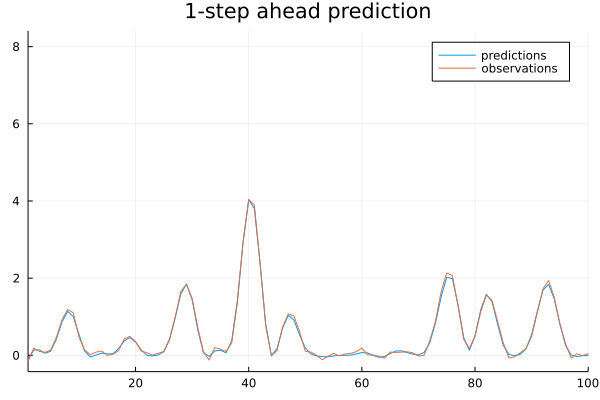

In [29]:
plot(sim[2:end], label="predictions")
plot!(output_tst, xlims=(1, 100), title="1-step ahead prediction", label="observations")